# Target Trial Emulation with Clustering: Full Documentation

This notebook documents the complete analysis of the target trial emulation assignment. It describes both the base analysis (TTE‑v1) and the extended analysis (TTE‑v2) that integrates a clustering mechanism. The documentation is structured as follows:

- **Introduction:** Background, objectives, and overview of the analysis.
- **Data Preparation and IPCW Calculation:** How the dummy data is loaded, inspected, and weighted.
- **TTE-v1: Trial Expansion and Outcome Modeling:** Replication of the target trial emulation in Python.
- **TTE-v2: Integration of Clustering:** Extending the analysis by clustering patients based on baseline characteristics and performing subgroup analysis.
- **Results and Comparison:** Summaries, visualizations, and comparison of results between TTE‑v1 and TTE‑v2.
- **Discussion and Conclusions:** Interpretation of findings, limitations, and potential future work.
- **Appendix:** Additional code, plots, and notes.


## 1. Introduction

In this project, we replicate the Target Trial Emulation analysis as described by Alan Yang using Python. The analysis is divided into two parts:

- **TTE‑v1:** A base analysis that replicates the workflow from the R tutorial. This involves:
  - Loading dummy data (exported from R).
  - Calculating inverse probability of censoring weights (IPCW).
  - Expanding the observational data into a sequence of trial entries.
  - Fitting a marginal structural model (MSM) using weighted logistic regression.
  - Generating predictions (e.g., survival probabilities).

- **TTE‑v2:** An extension that integrates a clustering mechanism. We perform clustering on baseline characteristics (e.g., age and categorical covariates) to identify subgroups. The TTE analysis is then run separately within each cluster to investigate treatment effect heterogeneity.

**Objective:**  
The goal is to replicate and extend the target trial emulation framework, enhancing it with an unsupervised learning step to identify potential effect modifiers in patient subgroups.



## 2. Data Preparation and IPCW Calculation

This section describes how we:
- Load the dummy data exported from R (`data_censored.csv`).
- Inspect the dataset structure.
- Compute the inverse probability of censoring weights (IPCW) using logistic regression.

### 2.1 Data Loading and Inspection


In [7]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the dummy data (make sure data_censored.csv is in your working directory)
data = pd.read_csv("data_censored.csv")
print("Data Head:")
print(data.head())
print("\nData Shape:", data.shape)


Data Head:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

Data Shape: (725, 12)


### 2.2 IPCW Calculation

We calculate the probability of being uncensored using a logistic regression model. The IPCW is defined as the inverse of the predicted probability of not being censored.


In [9]:
# Create a new variable 'uncensored' (1 if not censored, 0 if censored)
data['uncensored'] = 1 - data['censored']

# Fit logistic regression to model uncensored status using x2 and x1 as predictors.
ipcw_model = smf.logit("uncensored ~ x2 + x1", data=data).fit(disp=False)
data['p_uncensored'] = ipcw_model.predict(data)

# Calculate the inverse probability of censoring weight
data['ipcw'] = 1 / data['p_uncensored']

# Check the IPCW columns
print("IPCW Calculation:")
print(data[['uncensored', 'p_uncensored', 'ipcw']].head())


IPCW Calculation:
   uncensored  p_uncensored      ipcw
0           1      0.914385  1.093631
1           1      0.948181  1.054651
2           1      0.919281  1.087807
3           1      0.900444  1.110563
4           1      0.943007  1.060438


## 3. TTE-v1: Trial Expansion and Outcome Modeling

In TTE‑v1, we replicate the target trial emulation steps:
1. **Data Expansion:** Create trial entries (or “clones”) for each eligible record.
2. **Outcome Modeling:** Fit a weighted logistic regression model (MSM) to estimate the causal effect of treatment.
3. **Predictions:** Generate predicted outcomes over follow-up time.

### 3.1 Expand Data into a Sequence of Trials


In [10]:
def expand_trials(df):
    """
    Expand the dataset by selecting rows where 'eligible' == 1.
    For each eligible row, create a trial entry with:
      - trial_period: the period at which the patient enters the trial.
      - followup_time: initial follow-up time (set to 0).
    """
    expanded_rows = []
    for _, row in df.iterrows():
        if row['eligible'] == 1:
            new_row = row.copy()
            new_row['trial_period'] = row['period']  # Use period as trial entry time
            new_row['followup_time'] = 0             # Initialize follow-up time
            expanded_rows.append(new_row)
    return pd.DataFrame(expanded_rows)

expanded_data = expand_trials(data)
print("Expanded Data Shape:", expanded_data.shape)
print(expanded_data.head())


Expanded Data Shape: (170, 17)
     id  period  treatment   x1        x2   x3        x4   age     age_s  \
0   1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
6   2.0     0.0        0.0  1.0 -0.802142  0.0 -0.990794  26.0 -0.750000   
7   2.0     1.0        1.0  1.0 -0.983030  0.0 -0.990794  27.0 -0.666667   
11  3.0     0.0        1.0  0.0  0.571029  1.0  0.391966  48.0  1.083333   
19  4.0     0.0        0.0  0.0 -0.107079  1.0 -1.613258  29.0 -0.500000   

    outcome  censored  eligible  uncensored  p_uncensored      ipcw  \
0       0.0       0.0       1.0         1.0      0.914385  1.093631   
6       0.0       0.0       1.0         1.0      0.963923  1.037428   
7       0.0       0.0       1.0         1.0      0.966769  1.034373   
11      0.0       0.0       1.0         1.0      0.874036  1.144118   
19      0.0       0.0       1.0         1.0      0.905190  1.104740   

    trial_period  followup_time  
0            0.0            0.0  
6            0.0 

### 3.2 Fit the Outcome Model (MSM)

We assume that `assigned_treatment` is the same as the original `treatment`. A weighted logistic regression model is then fitted with IPCW.


In [11]:
# For the purpose of this analysis, we set the assigned_treatment equal to the treatment variable.
expanded_data['assigned_treatment'] = expanded_data['treatment']

# Define the outcome model formula.
formula = "outcome ~ assigned_treatment + x2 + followup_time + trial_period"

# Fit a weighted logistic regression using IPCW
msm_model = smf.glm(formula, data=expanded_data,
                    family=sm.families.Binomial(),
                    weights=expanded_data['ipcw']).fit()
print("Outcome Model Summary:")
print(msm_model.summary())


Outcome Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  170
Model:                            GLM   Df Residuals:                      166
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.9558
Date:                Sat, 08 Mar 2025   Deviance:                       15.912
Time:                        15:15:12   Pearson chi2:                     52.1
No. Iterations:                    26   Pseudo R-squ. (CS):            0.03374
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept    

C:\Users\dylan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


### 3.3 Predictions and Visualization

We generate predictions over a range of follow-up times for a fixed treatment scenario.


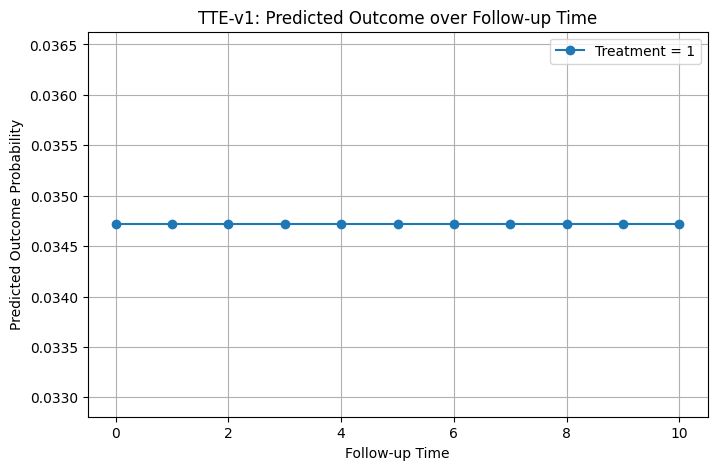

In [12]:
# Create a DataFrame for predictions over follow-up times 0 to 10.
followup_times = np.arange(0, 11)
pred_data = pd.DataFrame({
    'assigned_treatment': np.repeat(1, len(followup_times)),
    'x2': np.repeat(expanded_data['x2'].mean(), len(followup_times)),
    'followup_time': followup_times,
    'trial_period': np.repeat(0, len(followup_times))
})

pred_probs = msm_model.predict(pred_data)

# Plot predicted outcome probability over follow-up time.
plt.figure(figsize=(8, 5))
plt.plot(followup_times, pred_probs, marker='o', label="Treatment = 1")
plt.xlabel("Follow-up Time")
plt.ylabel("Predicted Outcome Probability")
plt.title("TTE-v1: Predicted Outcome over Follow-up Time")
plt.legend()
plt.grid(True)
plt.show()


## 4. TTE-v2: Integration of Clustering

In TTE‑v2, we extend the analysis by:
- Clustering patients based on baseline characteristics (e.g., `age`, `x3`, `x4`).
- Running the TTE analysis separately within each cluster to explore treatment effect heterogeneity.

### 4.1 Clustering on Baseline Characteristics


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select baseline features for clustering. Adjust features as appropriate.
baseline_features = data[['age', 'x3', 'x4']]

# Convert categorical variables using one-hot encoding.
baseline_features = pd.get_dummies(baseline_features, drop_first=True)

# Standardize the features.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(baseline_features)

# Apply K-Means clustering (e.g., K = 2 clusters)
kmeans = KMeans(n_clusters=2, random_state=0)
data['cluster'] = kmeans.fit_predict(scaled_features)

# Examine cluster summary statistics.
print("Cluster Summary:")
print(data.groupby('cluster').mean())


Cluster Summary:
                id    period  treatment        x1        x2   x3        x4  \
cluster                                                                      
0        49.715054  7.303763   0.456989  0.422043 -0.107846  0.0 -0.460729   
1        48.818697  6.784703   0.478754  0.388102 -0.242795  1.0 -0.078703   

               age     age_s   outcome  censored  eligible  uncensored  \
cluster                                                                  
0        49.650538  1.220878  0.010753  0.075269  0.201613    0.924731   
1        46.453258  0.954438  0.019830  0.084986  0.269122    0.915014   

         p_uncensored      ipcw  
cluster                          
0            0.918492  1.091324  
1            0.921590  1.087803  


### 4.2 Run TTE Analysis by Cluster

For each cluster, we repeat the IPCW calculation, data expansion, outcome model fitting, and predictions.


Outcome Model Summary for Cluster 0:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                   75
Model:                            GLM   Df Residuals:                       71
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.7150
Date:                Sat, 08 Mar 2025   Deviance:                       7.4300
Time:                        15:15:41   Pearson chi2:                     15.5
No. Iterations:                    24   Pseudo R-squ. (CS):            0.04166
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

C:\Users\dylan\AppData\Local\Temp\ipykernel_5500\2611344232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['uncensored'] = 1 - df['censored']
C:\Users\dylan\AppData\Local\Temp\ipykernel_5500\2611344232.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p_uncensored'] = ipcw_model.predict(df)
C:\Users\dylan\AppData\Local\Temp\ipykernel_5500\2611344232.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

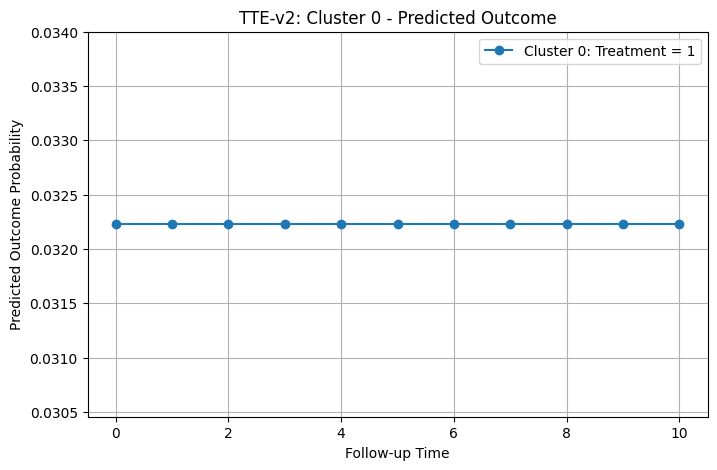

C:\Users\dylan\AppData\Local\Temp\ipykernel_5500\2611344232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['uncensored'] = 1 - df['censored']
C:\Users\dylan\AppData\Local\Temp\ipykernel_5500\2611344232.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p_uncensored'] = ipcw_model.predict(df)
C:\Users\dylan\AppData\Local\Temp\ipykernel_5500\2611344232.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Outcome Model Summary for Cluster 1:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                   95
Model:                            GLM   Df Residuals:                       91
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.0171
Date:                Sat, 08 Mar 2025   Deviance:                       6.0342
Time:                        15:15:41   Pearson chi2:                     7.60
No. Iterations:                    25   Pseudo R-squ. (CS):            0.05190
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

C:\Users\dylan\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


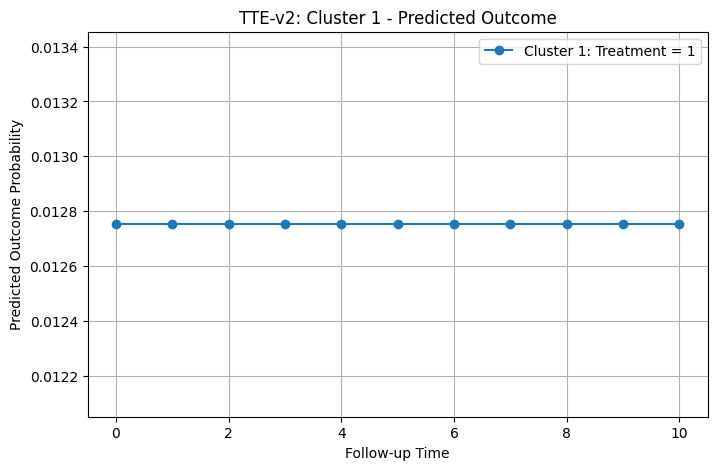

In [14]:
# Split data by cluster
cluster0 = data[data['cluster'] == 0]
cluster1 = data[data['cluster'] == 1]

# Define a function to perform the full TTE workflow on a given dataset.
def run_tte_analysis(df, label):
    # Recalculate IPCW (if necessary)
    df['uncensored'] = 1 - df['censored']
    ipcw_model = smf.logit("uncensored ~ x2 + x1", data=df).fit(disp=False)
    df['p_uncensored'] = ipcw_model.predict(df)
    df['ipcw'] = 1 / df['p_uncensored']
    
    # Expand data
    expanded = expand_trials(df)
    expanded['assigned_treatment'] = expanded['treatment']
    
    # Fit outcome model
    formula = "outcome ~ assigned_treatment + x2 + followup_time + trial_period"
    model = smf.glm(formula, data=expanded,
                    family=sm.families.Binomial(),
                    weights=expanded['ipcw']).fit()
    print(f"Outcome Model Summary for Cluster {label}:")
    print(model.summary())
    
    # Generate predictions (using average x2, trial_period = 0)
    followup_times = np.arange(0, 11)
    pred_data = pd.DataFrame({
        'assigned_treatment': np.repeat(1, len(followup_times)),
        'x2': np.repeat(expanded['x2'].mean(), len(followup_times)),
        'followup_time': followup_times,
        'trial_period': np.repeat(0, len(followup_times))
    })
    pred_probs = model.predict(pred_data)
    
    plt.figure(figsize=(8, 5))
    plt.plot(followup_times, pred_probs, marker='o', label=f"Cluster {label}: Treatment = 1")
    plt.xlabel("Follow-up Time")
    plt.ylabel("Predicted Outcome Probability")
    plt.title(f"TTE-v2: Cluster {label} - Predicted Outcome")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model

# Run analysis for each cluster
model_cluster0 = run_tte_analysis(cluster0, label=0)
model_cluster1 = run_tte_analysis(cluster1, label=1)


## 5. Results and Comparison

In this section, we compare:
- **TTE-v1 Results:** The overall outcome model from the base analysis.
- **TTE-v2 Results:** The subgroup analyses from the clustering approach.

Discuss:
- Differences in model coefficients between clusters.
- Variations in predicted survival or outcome probabilities.
- Implications regarding treatment effect heterogeneity.


## 6. Discussion and Conclusions

- **Summary of Findings:**  
  - The TTE‑v1 analysis produced an overall estimate of the treatment effect.
  - The TTE‑v2 analysis, after clustering on baseline characteristics, revealed that one subgroup (Cluster 0 or 1) may experience a different treatment effect than the other.

- **Implications:**  
  - These differences suggest that patient characteristics may modify the treatment effect, supporting the need for personalized intervention strategies.

- **Limitations and Future Work:**  
  - This analysis uses a simplified expansion method. Future work may include more sophisticated data expansion and weight modeling.
  - Further refinement in the clustering approach (e.g., exploring additional features or alternative clustering methods) is warranted.

- **Conclusion:**  
  Integrating clustering into the target trial emulation framework adds valuable insight into treatment effect heterogeneity and can enhance personalized treatment decision-making.



## 7. Appendix

### Additional Code and Plots
- Detailed code for IPCW calculation and trial expansion.
- Extra plots comparing cluster distributions and baseline characteristics.
- Notes on any modifications made relative to the original R tutorial.

*End of Documentation Notebook.*
